In [7]:
library(ggplot2)
library(umap)
library(MOFA2)
library(SingleCellExperiment)


Attaching package: ‘MOFA2’

The following object is masked from ‘package:stats’:

    predict

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, row

In [56]:
### Neuroseq 10x data
### DA - all conditions (D30, D52, D52ROT)
### meta-cells
df = read.csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/DA_phenotype_wo_outliers.tsv", sep="\t")

In [60]:
nrow(df)

[1] 9432

In [58]:
df[1:5,1:5]

pseudocell_id,MIR1302.10,FAM138A,OR4F5,RP11.34P13.7
HPSI0714i-iudw_1--DA--d30--0,0,0,0,0
HPSI0714i-iudw_1--DA--d30--1,0,0,0,0
HPSI0714i-iudw_1--DA--d30--2,0,0,0,0
HPSI0714i-iudw_1--DA--d30--3,0,0,0,0
HPSI0714i-iudw_1--DA--d30--4,0,0,0,0


In [59]:
# rownames(df) = df$pseudocell_id
# df$pseudocell_id = c()
df[1:5,1:5]

,MIR1302.10,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8
HPSI0714i-iudw_1--DA--d30--0,0,0,0,0,0
HPSI0714i-iudw_1--DA--d30--1,0,0,0,0,0
HPSI0714i-iudw_1--DA--d30--2,0,0,0,0,0
HPSI0714i-iudw_1--DA--d30--3,0,0,0,0,0
HPSI0714i-iudw_1--DA--d30--4,0,0,0,0,0


In [67]:
df0 = data.frame(pseudocell = rownames(df))
df0$celltype = "DA"
df0$donor = gsub("--DA.*","",df0$pseudocell)
df0$cluster = gsub(".*--","",df0$pseudocell)
df0$condition = gsub("--.*","",gsub(".*DA--","",df0$pseudocell))
head(df0)

pseudocell,celltype,donor,cluster,condition
HPSI0714i-iudw_1--DA--d30--0,DA,HPSI0714i-iudw_1,0,d30
HPSI0714i-iudw_1--DA--d30--1,DA,HPSI0714i-iudw_1,1,d30
HPSI0714i-iudw_1--DA--d30--2,DA,HPSI0714i-iudw_1,2,d30
HPSI0714i-iudw_1--DA--d30--3,DA,HPSI0714i-iudw_1,3,d30
HPSI0714i-iudw_1--DA--d30--4,DA,HPSI0714i-iudw_1,4,d30
HPSI0714i-iudw_1--DA--d30--5,DA,HPSI0714i-iudw_1,5,d30


In [72]:
length(unique(df0$donor))
unique(df0$condition)

[1] 191

[1] "d30"      "d52_untr" "d52_tr"

In [73]:
# build the sce object
sce <- SingleCellExperiment(
assays = list(counts = t(df)),
colData = df0)
sce

class: SingleCellExperiment 
dim: 32738 9432 
metadata(0):
assays(1): counts
rownames(32738): MIR1302.10 FAM138A ... AC002321.2 AC002321.1
rowData names(0):
colnames(9432): HPSI0714i-iudw_1--DA--d30--0
  HPSI0714i-iudw_1--DA--d30--1 ... HPSI0114i-rozh_4--DA--d52_tr--11
  HPSI0114i-rozh_4--DA--d52_tr--12
colData names(5): pseudocell celltype donor cluster condition
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [74]:
logcounts(sce) = counts(sce)

In [95]:
saveRDS(sce, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/DA_phenotype_wo_outliers_sce.rds")

In [11]:
sce = readRDS("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/DA_phenotype_wo_outliers_sce.rds")

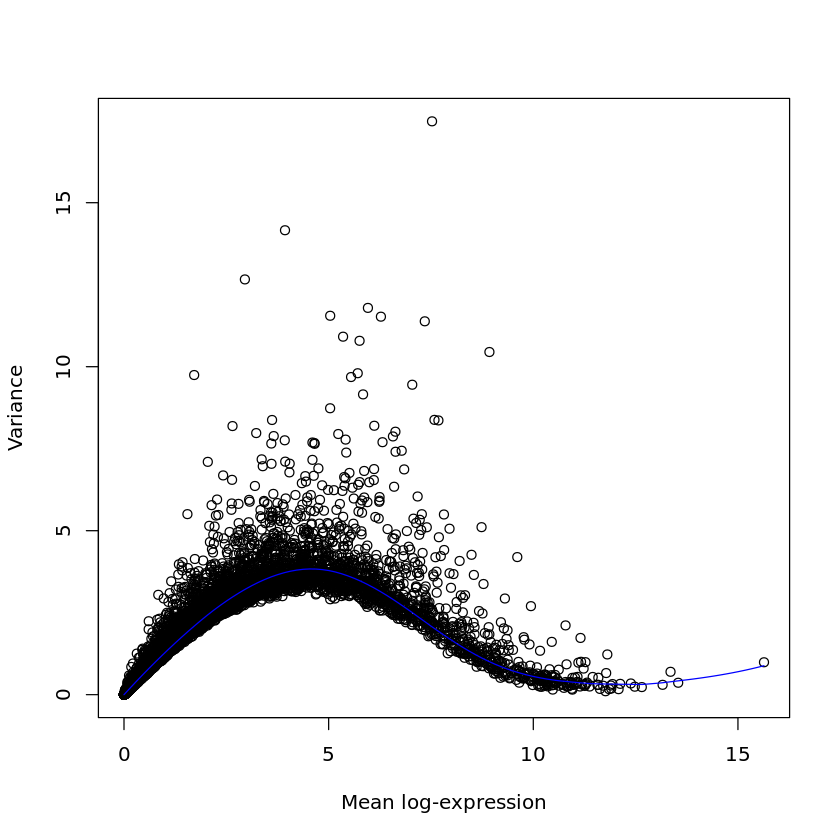

In [12]:
dec1 <- scran::modelGeneVar(sce)
plot(dec1$mean, dec1$total, xlab="Mean log-expression", ylab="Variance")
curve(metadata(dec1)$trend(x), col="blue", add=TRUE)

In [26]:
top.500.hvgs = rownames(dec1[order(dec1$bio, decreasing = TRUE),][1:500,])

In [27]:
df_pca = as.data.frame(prcomp(t(logcounts(sce[rownames(sce) %in% top.500.hvgs,])))$x)

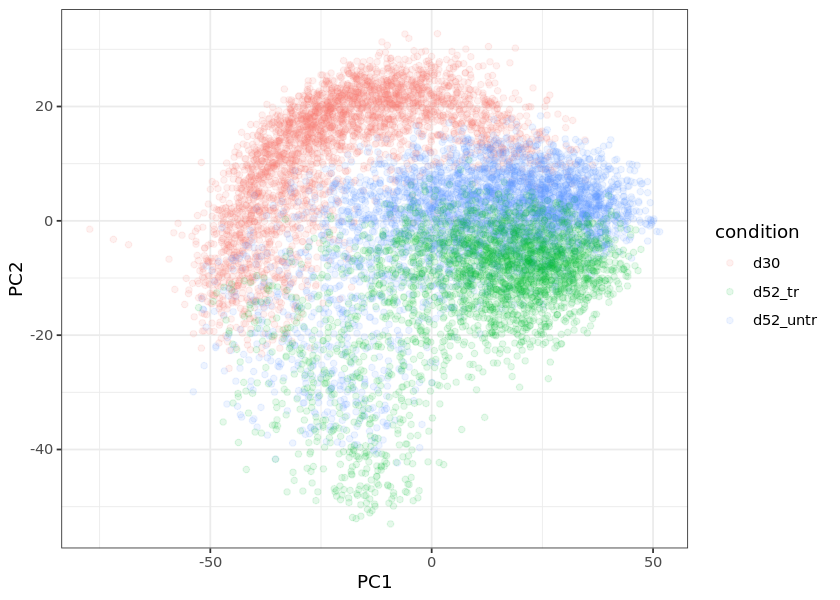

In [15]:
options(repr.plot.width = 7, repr.plot.height = 5)
df_pca$condition = sce$condition
p = ggplot(df_pca, aes(x = PC1, y = PC2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [29]:
### tSNE
library(Rtsne)
tsne = Rtsne(df_pca)

df_tsne = data.frame(tsne$Y)
colnames(df_tsne) = c("tSNE1","tSNE2")
df_tsne$condition = sce$condition

In [32]:
nrow(df_tsne)

[1] 9432

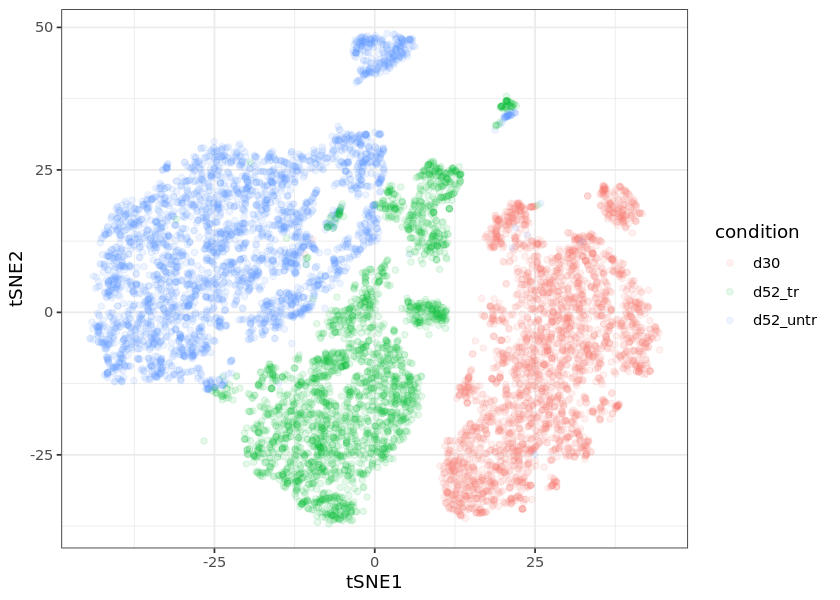

In [30]:
p = ggplot(df_tsne, aes(x = tSNE1, y = tSNE2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [16]:
umap = umap(df_pca[,1:200])

df_umap = data.frame(umap$layout)
colnames(df_umap) = c("UMAP1","UMAP2")
head(df_umap,2)

,UMAP1,UMAP2
HPSI0714i-iudw_1--DA--d30--0,-3.963363,9.211561
HPSI0714i-iudw_1--DA--d30--1,-1.857423,8.675704


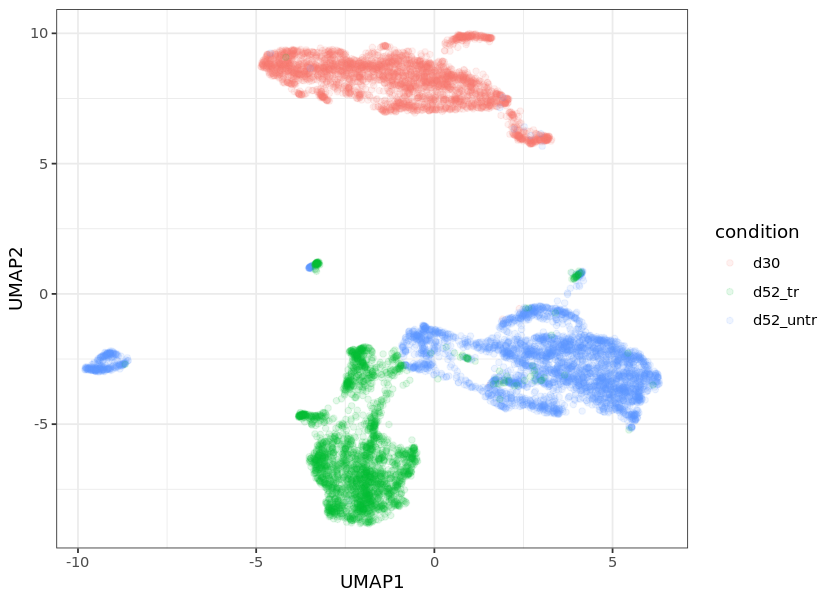

In [17]:
df_umap$condition = sce$condition
p = ggplot(df_umap, aes(x = UMAP1, y = UMAP2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [33]:
remove_cells1 = rownames(df_umap[df_umap$UMAP1< -5,])
remove_cells2 = rownames(df_umap[df_umap$UMAP2 > 0 & df_umap$UMAP2< 5,])

In [35]:
sce_sel = sce[,!(colnames(sce) %in% c(remove_cells1, remove_cells2))]
sce_sel

class: SingleCellExperiment 
dim: 32738 9219 
metadata(0):
assays(2): counts logcounts
rownames(32738): MIR1302.10 FAM138A ... AC002321.2 AC002321.1
rowData names(0):
colnames(9219): HPSI0714i-iudw_1--DA--d30--0
  HPSI0714i-iudw_1--DA--d30--1 ... HPSI0114i-rozh_4--DA--d52_tr--11
  HPSI0114i-rozh_4--DA--d52_tr--12
colData names(5): pseudocell celltype donor cluster condition
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [46]:
saveRDS(sce_sel, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/DA_phenotype_wo_outliers2_sce.rds")

In [37]:
dec1 <- scran::modelGeneVar(sce_sel)
top.500.hvgs = rownames(dec1[order(dec1$bio, decreasing = TRUE),][1:500,])
df_pca0 = as.data.frame(prcomp(t(logcounts(sce_sel[rownames(sce_sel) %in% top.500.hvgs,])))$x)

In [38]:
df_tsne0 = data.frame(Rtsne(df_pca0)$Y)
colnames(df_tsne0) = c("tSNE1","tSNE2")
df_tsne0$condition = sce_sel$condition

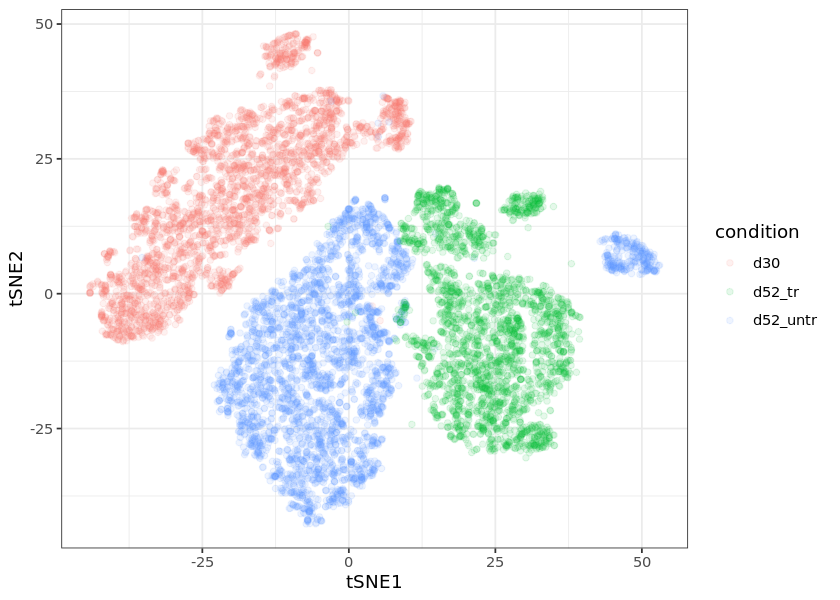

In [39]:
p = ggplot(df_tsne0, aes(x = tSNE1, y = tSNE2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [40]:
data = list(scRNAseq = logcounts(sce_sel[rownames(sce_sel) %in% top.500.hvgs,]))
MOFAobject <- create_mofa(data)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...

No groups provided as argument... we assume that all samples are coming from the same group.



In [41]:
data_opts <- get_default_data_options(MOFAobject)
# data_opts$use_float32 <- TRUE # next time run like this to be faster

In [42]:
model_opts <- get_default_model_options(MOFAobject)
model_opts$num_factors <- 20
model_opts$spikeslab_weights <- FALSE

In [43]:
train_opts <- get_default_training_options(MOFAobject)
train_opts$convergence_mode <- "medium"
train_opts$seed <- 42

In [44]:
#########################
## Prepare MOFA object ##
#########################

MOFAobject <- prepare_mofa(MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
  # stochastic_options = stochastic_opts
)

Checking data options...
Checking training options...
Checking model options...


In [45]:
#####################
## Train the model ##
#####################

outfile <- "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/mofa20_pseudocells4_wo_outliers.hdf5"
MOFAmodel <- run_mofa(MOFAobject, outfile)

ERROR: Error: Unable to read dataset.
Not all required filters available.
Missing filters: deflate
